In [207]:
import csv
import numpy as np
import pandas as pd

In [208]:
enron = pd.read_csv(f'./input/enron/messages.csv').fillna(' ')
X_enron = np.array(enron['message'])
y_enron = np.array(enron['label'])

In [209]:
ling_spam = pd.read_csv(f'./input/ling_spam_copy/messages.csv').fillna(' ')
X_ling_spam = np.array(ling_spam['message'])
y_ling_spam = np.array(ling_spam['label'])

In [210]:
spam_assasin = pd.read_csv(f'./input/spam_assasin_copy/messages.csv').fillna(' ')
X_spam_assasin = np.array(spam_assasin['message'])
y_spam_assasin = np.array(spam_assasin['label'])

In [300]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.calibration import CalibratedClassifierCV
from nltk.corpus import stopwords
from matplotlib import pyplot

In [301]:
from mealpy.swarm_based import AO, HGS, SSA, MRFO, HHO

def resolve_dataset(name):
    if (name == 'enron'):
        return [X_enron, y_enron]
    elif (name == 'ling_spam'):
        return [X_ling_spam, y_ling_spam]
    elif (name == 'spam_assasin'):
        return [X_spam_assasin, y_spam_assasin]
    else:
        return
    
def resolve_clf(alg):
    if alg == 'AO':
        return AO.OriginalAO
    elif alg == 'HGS':
        return HGS.OriginalHGS
    elif alg == 'SSA':
        return SSA.OriginalSSA
    elif alg == 'MRFO':
        return MRFO.BaseMRFO
    elif alg == 'HHO':
        return HHO.BaseHHO


def test_bio_alg(clf, obj_function):
    problem = {
        'obj_func': obj_function,
        'lb': [0.0001, 0.0001, 0.0001],
        'ub': [1000, 1000, 1000],
        'minmax': 'max',
        'verbose': True,
    }
    model = clf(problem, epoch=10, pop_size=40)
    model.solve()
    return model.g_best

In [302]:
def get_best(alg, dataset):
    [X, y] = resolve_dataset(dataset)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

    # tokenization
    cv = TfidfVectorizer(stop_words=stopwords.words('english'))
    X_train = cv.fit_transform(X_train)
    X_test = cv.transform(X_test)

    if (alg == 'RSCV'):
        tuned_parameters = {
            'epsilon': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
            'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
            'tol': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
        }
        
        sgd = SGDClassifier(random_state=0, early_stopping=True)
        clf = RandomizedSearchCV(estimator=sgd, param_distributions=tuned_parameters, n_iter = 100, random_state = 42, verbose=1, n_jobs=-1, scoring='roc_auc')
        clf.fit(X_train, y_train)
        params = clf.best_params_
        
        return [params['alpha'], params['epsilon'], params['tol']]
    
    elif alg == "DEFAULT": return [0.0001, 0.1, 1e-3]

    def obj_function(solution):
        alpha, epsilon, tol = solution
        clf = SGDClassifier(random_state=0, early_stopping=True, alpha=alpha, epsilon=epsilon, tol=tol)
        clf.fit(X_train, y_train)
        return roc_auc_score(y_test, clf.decision_function(X_test))

    clf = resolve_clf(alg)
    best_params_ = test_bio_alg(clf, obj_function)

    return best_params_[0]

In [322]:
def test(train, test, alg):
    [X, y] = resolve_dataset(train)
    [X2, y2] = resolve_dataset(test)

    params = get_best(alg, train)

    # split dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

    # tokenization
    cv = TfidfVectorizer(stop_words=stopwords.words('english'))
    X_train = cv.fit_transform(X_train)
    X_test = cv.transform(X_test)

    clf = SGDClassifier(random_state=0, early_stopping=True, alpha=params[0], epsilon=params[1], tol=params[2])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    print(f'\nLearned with {train} - tested with {test}')
    print(f'Params: {params} provided by {alg}\n')
    print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
    print(f'Precision: {precision_score(y_test, y_pred)}')
    print(f'Recall: {recall_score(y_test, y_pred)}')
    print(f'F1-score: {f1_score(y_test, y_pred)}\n')

    X2_ = cv.transform(X2)

    y_score = clf.decision_function(X_train)
    y_test_score = clf.decision_function(X_test)
    y2_score = clf.decision_function(X2_)
    y2_pred = clf.predict(X2_)

    print(f'Pred Accuracy: {accuracy_score(y2, y2_pred)}')
    print(f'Pred Precision: {precision_score(y2, y2_pred)}')
    print(f'Pred Recall: {recall_score(y2, y2_pred)}')
    print(f'Pred F1-score: {f1_score(y2, y2_pred)}')
    print(f'Pred ROC aut score: {roc_auc_score(y2, y2_score)}')

    ns_probs = [0 for _ in range(len(y2))]
    ns_auc = roc_auc_score(y2, ns_probs)
    y2_auc = roc_auc_score(y2, y2_score)
    y_auc = roc_auc_score(y_train, y_score)
    y_test_auc = roc_auc_score(y_test, y_test_score)
    
    print(f'No Skill: ROC AUC={ns_auc}')
    print(f'Applied: ROC AUC={y2_auc}')
    print(f'Trained: ROC AUC={y_auc}')
    print(f'Trained: ROC AUC={y_test_auc}')
    
    ns_fpr, ns_tpr, _ = roc_curve(y2, ns_probs)
    y2_fpr, y2_tpr, _ = roc_curve(y2, y2_score)
    y_fpr, y_tpr, _ = roc_curve(y_train, y_score)
    y_test_fpr, y_test_tpr, _ = roc_curve(y_test, y_test_score)
    
    pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Без навыков')
    pyplot.plot(y2_fpr, y2_tpr, marker='.', label='Проверка')
    pyplot.plot(y_fpr, y_tpr, marker='.', label='train')
    pyplot.plot(y_test_fpr, y_test_tpr, marker='.', label='test')
    
    pyplot.xlabel('Ошибка первого рода')
    pyplot.ylabel('Чувствительность')
    pyplot.legend()
    pyplot.show()


Learned with enron - tested with ling_spam
Params: [0.0001, 0.1, 0.001] provided by DEFAULT

Accuracy: 0.9886107486060031
Precision: 0.9802002730996814
Recall: 0.9979147358665431
F1-score: 0.9889781859931114

Pred Accuracy: 0.7411642411642412
Pred Precision: 0.6606648199445984
Pred Recall: 0.9916839916839917
Pred F1-score: 0.7930174563591023
Pred ROC aut score: 0.9509381442853375
No Skill: ROC AUC=0.5
Applied: ROC AUC=0.9509381442853375
Trained: ROC AUC=0.9997288438775525
Trained: ROC AUC=0.9992780413017159


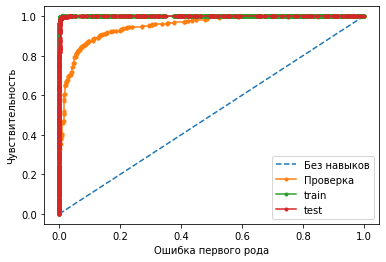

In [323]:
test(train='enron', test='ling_spam', alg='DEFAULT')

Fitting 5 folds for each of 100 candidates, totalling 500 fits

Learned with enron - tested with ling_spam
Params: [0.0001, 0.001, 0.001] provided by RSCV

Accuracy: 0.9899157669948986
Precision: 0.9828532235939643
Recall: 0.9976792759340914
F1-score: 0.9902107566509271

Pred Accuracy: 0.7297297297297297
Pred Precision: 0.6507503410641201
Pred Recall: 0.9916839916839917
Pred F1-score: 0.785831960461285
Pred ROC aut score: 0.9514006249972986
No Skill: ROC AUC=0.5
Applied: ROC AUC=0.9514006249972986


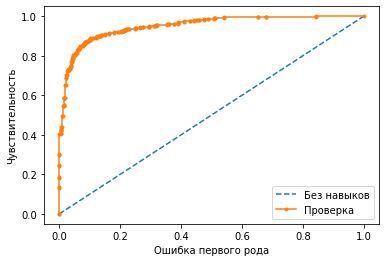

In [262]:
test(train='enron', test='ling_spam', alg='RSCV')

> Epoch: 1, Current best: 0.9985610892986765, Global best: 0.9985610892986765, Runtime: 5.72204 seconds
> Epoch: 2, Current best: 0.9985610892986765, Global best: 0.9985610892986765, Runtime: 5.80399 seconds
> Epoch: 3, Current best: 0.9985610892986765, Global best: 0.9985610892986765, Runtime: 5.19401 seconds
> Epoch: 4, Current best: 0.9985610892986765, Global best: 0.9985610892986765, Runtime: 5.96847 seconds
> Epoch: 5, Current best: 0.9985610892986765, Global best: 0.9985610892986765, Runtime: 4.90459 seconds
> Epoch: 6, Current best: 0.9985610892986765, Global best: 0.9985610892986765, Runtime: 5.14273 seconds
> Epoch: 7, Current best: 0.9985683018836454, Global best: 0.9985683018836454, Runtime: 5.55002 seconds
> Epoch: 8, Current best: 0.9985768668282963, Global best: 0.9985768668282963, Runtime: 4.80813 seconds
> Epoch: 9, Current best: 0.9985768668282963, Global best: 0.9985768668282963, Runtime: 5.31841 seconds
> Epoch: 10, Current best: 0.9985768668282963, Global best: 0.99

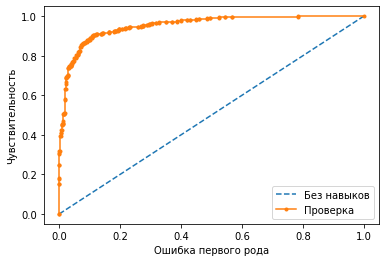

In [263]:
test(train='enron', test='ling_spam', alg='MRFO')

> Epoch: 1, Current best: 0.9989077843528885, Global best: 0.9989077843528885, Runtime: 3.56071 seconds
> Epoch: 2, Current best: 0.9989077843528885, Global best: 0.9989077843528885, Runtime: 6.55069 seconds
> Epoch: 3, Current best: 0.9989077843528885, Global best: 0.9989077843528885, Runtime: 8.01658 seconds
> Epoch: 4, Current best: 0.9989077843528885, Global best: 0.9989077843528885, Runtime: 8.50317 seconds
> Epoch: 5, Current best: 0.9989077843528885, Global best: 0.9989077843528885, Runtime: 8.75178 seconds
> Epoch: 6, Current best: 0.9989077843528885, Global best: 0.9989077843528885, Runtime: 9.66887 seconds
> Epoch: 7, Current best: 0.9989077843528885, Global best: 0.9989077843528885, Runtime: 9.67020 seconds
> Epoch: 8, Current best: 0.9989077843528885, Global best: 0.9989077843528885, Runtime: 10.01277 seconds
> Epoch: 9, Current best: 0.9989077843528885, Global best: 0.9989077843528885, Runtime: 9.77145 seconds
> Epoch: 10, Current best: 0.9989077843528885, Global best: 0.9

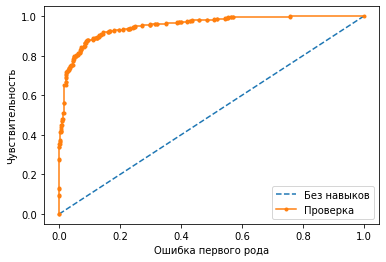

In [264]:
test(train='enron', test='ling_spam', alg='HGS')

> Epoch: 1, Current best: 0.9987748990298303, Global best: 0.9987748990298303, Runtime: 2.91696 seconds
> Epoch: 2, Current best: 0.9987748990298303, Global best: 0.9987748990298303, Runtime: 2.62198 seconds
> Epoch: 3, Current best: 0.9987748990298303, Global best: 0.9987748990298303, Runtime: 2.74825 seconds
> Epoch: 4, Current best: 0.9987748990298303, Global best: 0.9987748990298303, Runtime: 2.59142 seconds
> Epoch: 5, Current best: 0.9987748990298303, Global best: 0.9987748990298303, Runtime: 2.65680 seconds
> Epoch: 6, Current best: 0.9987748990298303, Global best: 0.9987748990298303, Runtime: 2.70974 seconds
> Epoch: 7, Current best: 0.9987748990298303, Global best: 0.9987748990298303, Runtime: 7.23024 seconds
> Epoch: 8, Current best: 0.9987748990298303, Global best: 0.9987748990298303, Runtime: 6.59460 seconds
> Epoch: 9, Current best: 0.9987748990298303, Global best: 0.9987748990298303, Runtime: 6.22971 seconds
> Epoch: 10, Current best: 0.9987748990298303, Global best: 0.99

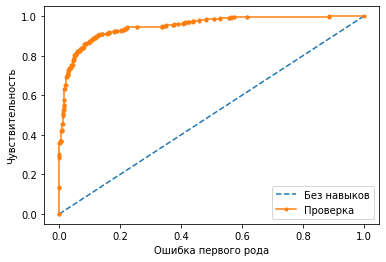

In [265]:
test(train='enron', test='ling_spam', alg='AO')

> Epoch: 1, Current best: 0.9988263089240049, Global best: 0.9988263089240049, Runtime: 4.47988 seconds
> Epoch: 2, Current best: 0.9988263089240049, Global best: 0.9988263089240049, Runtime: 6.92137 seconds
> Epoch: 3, Current best: 0.9988263089240049, Global best: 0.9988263089240049, Runtime: 5.67097 seconds
> Epoch: 4, Current best: 0.9988263089240049, Global best: 0.9988263089240049, Runtime: 5.14576 seconds
> Epoch: 5, Current best: 0.9988263089240049, Global best: 0.9988263089240049, Runtime: 6.45594 seconds
> Epoch: 6, Current best: 0.9988263089240049, Global best: 0.9988263089240049, Runtime: 4.98540 seconds
> Epoch: 7, Current best: 0.9988263089240049, Global best: 0.9988263089240049, Runtime: 5.38604 seconds
> Epoch: 8, Current best: 0.9988263089240049, Global best: 0.9988263089240049, Runtime: 4.14934 seconds
> Epoch: 9, Current best: 0.9988263089240049, Global best: 0.9988263089240049, Runtime: 4.19902 seconds
> Epoch: 10, Current best: 0.9988263089240049, Global best: 0.99

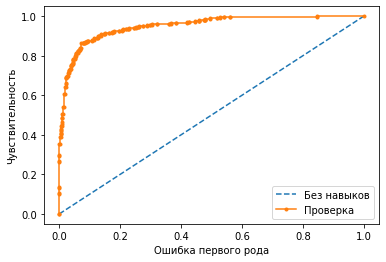

In [266]:
test(train='enron', test='ling_spam', alg='HHO')


Learned with spam_assasin - tested with ling_spam
Params: [0.0001, 0.1, 0.001] provided by DEFAULT

Accuracy: 0.9982471516213848
Precision: 1.0
Recall: 0.9965457685664939
F1-score: 0.9982698961937717

Pred Accuracy: 0.7463617463617463
Pred Precision: 0.6657342657342658
Pred Recall: 0.9896049896049897
Pred F1-score: 0.7959866220735787
Pred ROC aut score: 0.9576333089846603
No Skill: ROC AUC=0.5
Applied: ROC AUC=0.9576333089846603
Trained: ROC AUC=0.9999781251773057
Trained: ROC AUC=0.9999293173283179


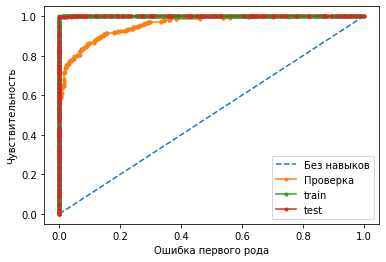

In [324]:
test(train='spam_assasin', test='ling_spam', alg='DEFAULT')

Fitting 5 folds for each of 100 candidates, totalling 500 fits

Learned with spam_assasin - tested with ling_spam
Params: [0.0001, 0.001, 0.01] provided by RSCV

Accuracy: 0.9982471516213848
Precision: 1.0
Recall: 0.9964726631393298
F1-score: 0.9982332155477032

Pred Accuracy: 0.7182952182952183
Pred Precision: 0.6407506702412868
Pred Recall: 0.9937629937629938
Pred F1-score: 0.7791361043194786
Pred ROC aut score: 0.9573221070102568
No Skill: ROC AUC=0.5
Applied: ROC AUC=0.9573221070102568
Trained: ROC AUC=0.9999736823936581
Trained: ROC AUC=0.9999969274069157


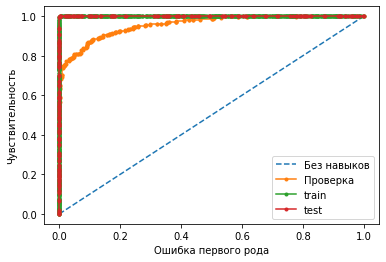

In [325]:
test(train='spam_assasin', test='ling_spam', alg='RSCV')

> Epoch: 1, Current best: 0.9987892867239452, Global best: 0.9987892867239452, Runtime: 1.31070 seconds
> Epoch: 2, Current best: 0.9987892867239452, Global best: 0.9987892867239452, Runtime: 1.06928 seconds
> Epoch: 3, Current best: 0.9989337119116979, Global best: 0.9989337119116979, Runtime: 0.94148 seconds
> Epoch: 4, Current best: 0.9989337119116979, Global best: 0.9989337119116979, Runtime: 1.03292 seconds
> Epoch: 5, Current best: 0.9989644406750495, Global best: 0.9989644406750495, Runtime: 0.93964 seconds
> Epoch: 6, Current best: 0.9991488132551593, Global best: 0.9991488132551593, Runtime: 0.91495 seconds
> Epoch: 7, Current best: 0.9991488132551593, Global best: 0.9991488132551593, Runtime: 0.91262 seconds
> Epoch: 8, Current best: 0.9991488132551593, Global best: 0.9991488132551593, Runtime: 0.96668 seconds
> Epoch: 9, Current best: 0.9991488132551593, Global best: 0.9991488132551593, Runtime: 0.91910 seconds
> Epoch: 10, Current best: 0.9991488132551593, Global best: 0.99

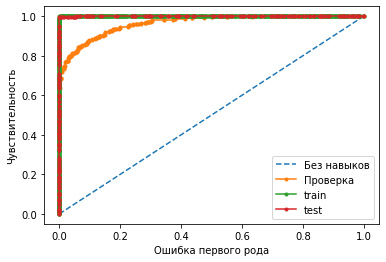

In [326]:
test(train='spam_assasin', test='ling_spam', alg='MRFO')

> Epoch: 1, Current best: 0.9999477588548741, Global best: 0.9999477588548741, Runtime: 0.89126 seconds
> Epoch: 2, Current best: 0.9999508318634109, Global best: 0.9999508318634109, Runtime: 0.72403 seconds
> Epoch: 3, Current best: 0.9999631238975581, Global best: 0.9999631238975581, Runtime: 0.61176 seconds
> Epoch: 4, Current best: 0.9999631238975581, Global best: 0.9999631238975581, Runtime: 0.59285 seconds
> Epoch: 5, Current best: 0.9999631238975583, Global best: 0.9999631238975583, Runtime: 0.61924 seconds
> Epoch: 6, Current best: 0.9999631238975583, Global best: 0.9999631238975583, Runtime: 0.64546 seconds
> Epoch: 7, Current best: 0.999966196906095, Global best: 0.999966196906095, Runtime: 0.63148 seconds
> Epoch: 8, Current best: 0.999966196906095, Global best: 0.999966196906095, Runtime: 0.58873 seconds
> Epoch: 9, Current best: 0.9999661969060951, Global best: 0.9999661969060951, Runtime: 0.57798 seconds
> Epoch: 10, Current best: 0.9999661969060951, Global best: 0.999966

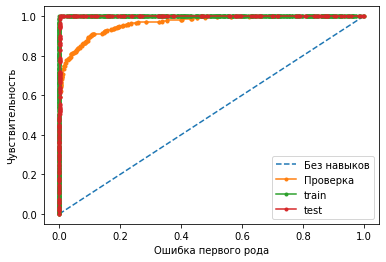

In [327]:
test(train='spam_assasin', test='ling_spam', alg='HGS')

> Epoch: 1, Current best: 0.9992779406252112, Global best: 0.9992779406252112, Runtime: 0.71465 seconds
> Epoch: 2, Current best: 0.9992779406252112, Global best: 0.9992779406252112, Runtime: 0.90002 seconds
> Epoch: 3, Current best: 0.9992779406252112, Global best: 0.9992779406252112, Runtime: 0.67884 seconds
> Epoch: 4, Current best: 0.9997572651463476, Global best: 0.9997572651463476, Runtime: 0.78089 seconds
> Epoch: 5, Current best: 0.9997572651463476, Global best: 0.9997572651463476, Runtime: 0.80812 seconds
> Epoch: 6, Current best: 0.9997572651463476, Global best: 0.9997572651463476, Runtime: 0.64212 seconds
> Epoch: 7, Current best: 0.9997572651463476, Global best: 0.9997572651463476, Runtime: 0.58715 seconds
> Epoch: 8, Current best: 0.9997572651463476, Global best: 0.9997572651463476, Runtime: 0.75588 seconds
> Epoch: 9, Current best: 0.9997572651463476, Global best: 0.9997572651463476, Runtime: 0.65981 seconds
> Epoch: 10, Current best: 0.9997572651463476, Global best: 0.99

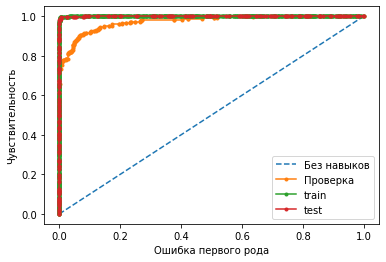

In [328]:
test(train='spam_assasin', test='ling_spam', alg='AO')

> Epoch: 1, Current best: 0.9998861853640529, Global best: 0.9998861853640529, Runtime: 1.12737 seconds
> Epoch: 2, Current best: 0.9998861853640529, Global best: 0.9998861853640529, Runtime: 0.77791 seconds
> Epoch: 3, Current best: 0.9998861853640529, Global best: 0.9998861853640529, Runtime: 0.80457 seconds
> Epoch: 4, Current best: 0.9998861853640529, Global best: 0.9998861853640529, Runtime: 0.76060 seconds
> Epoch: 5, Current best: 0.9998861853640529, Global best: 0.9998861853640529, Runtime: 0.80055 seconds
> Epoch: 6, Current best: 0.9998861853640529, Global best: 0.9998861853640529, Runtime: 0.91174 seconds
> Epoch: 7, Current best: 0.9998861853640529, Global best: 0.9998861853640529, Runtime: 1.20497 seconds
> Epoch: 8, Current best: 0.9998861853640529, Global best: 0.9998861853640529, Runtime: 0.98745 seconds
> Epoch: 9, Current best: 0.9998892614352949, Global best: 0.9998892614352949, Runtime: 1.03187 seconds
> Epoch: 10, Current best: 0.9998892614352949, Global best: 0.99

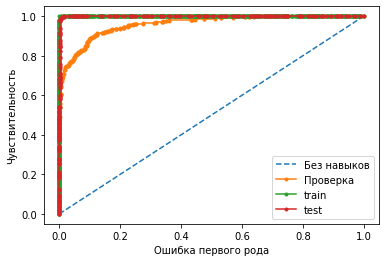

In [329]:
test(train='spam_assasin', test='ling_spam', alg='HHO')


Learned with ling_spam - tested with spam_assasin
Params: [0.0001, 0.1, 0.001] provided by DEFAULT

Accuracy: 0.995850622406639
Precision: 1.0
Recall: 0.9918032786885246
F1-score: 0.9958847736625513

Pred Accuracy: 0.8546690048224463
Pred Precision: 0.8076045627376426
Pred Recall: 0.9311705392371766
Pred F1-score: 0.8649969456322542
Pred ROC aut score: 0.9470959901486864
No Skill: ROC AUC=0.5
Applied: ROC AUC=0.9470959901486864
Trained: ROC AUC=1.0
Trained: ROC AUC=0.9999311199889792


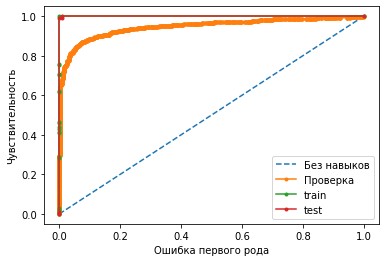

In [332]:
test(train='ling_spam', test='spam_assasin', alg='DEFAULT')

Fitting 5 folds for each of 100 candidates, totalling 500 fits

Learned with ling_spam - tested with spam_assasin
Params: [0.01, 0.1, 0.001] provided by RSCV

Accuracy: 0.991701244813278
Precision: 1.0
Recall: 0.983739837398374
F1-score: 0.9918032786885246

Pred Accuracy: 0.8147742218325296
Pred Precision: 0.7537102473498233
Pred Recall: 0.9351161771153003
Pred F1-score: 0.8346703189199763
Pred ROC aut score: 0.9360074004014253
No Skill: ROC AUC=0.5
Applied: ROC AUC=0.9360074004014253
Trained: ROC AUC=0.9999923049694507
Trained: ROC AUC=0.9997933030177759


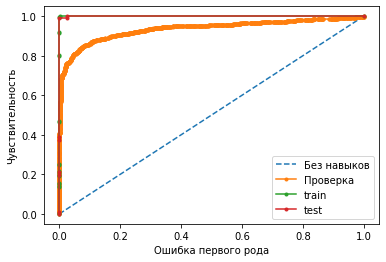

In [333]:
test(train='ling_spam', test='spam_assasin', alg='RSCV')

> Epoch: 1, Current best: 0.9999307862679956, Global best: 0.9999307862679956, Runtime: 0.63088 seconds
> Epoch: 2, Current best: 0.9999307862679956, Global best: 0.9999307862679956, Runtime: 0.71806 seconds
> Epoch: 3, Current best: 0.9999307862679956, Global best: 0.9999307862679956, Runtime: 0.62787 seconds
> Epoch: 4, Current best: 0.9999307862679956, Global best: 0.9999307862679956, Runtime: 0.57887 seconds
> Epoch: 5, Current best: 0.9999307862679956, Global best: 0.9999307862679956, Runtime: 0.58175 seconds
> Epoch: 6, Current best: 0.9999307862679956, Global best: 0.9999307862679956, Runtime: 0.62022 seconds
> Epoch: 7, Current best: 0.9999307862679956, Global best: 0.9999307862679956, Runtime: 0.60681 seconds
> Epoch: 8, Current best: 0.9999307862679956, Global best: 0.9999307862679956, Runtime: 0.66782 seconds
> Epoch: 9, Current best: 0.9999307862679956, Global best: 0.9999307862679956, Runtime: 0.71418 seconds
> Epoch: 10, Current best: 0.9999307862679956, Global best: 0.99

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Pred Accuracy: 0.5
Pred Precision: 0.0
Pred Recall: 0.0
Pred F1-score: 0.0
Pred ROC aut score: 0.9165532857155763
No Skill: ROC AUC=0.5
Applied: ROC AUC=0.9165532857155763
Trained: ROC AUC=0.999976910644193
Trained: ROC AUC=0.9995169082125603


/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


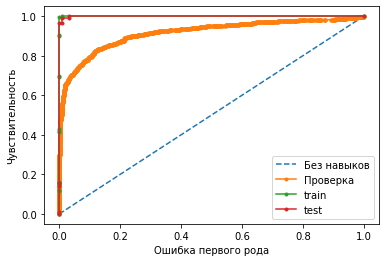

In [335]:
test(train='ling_spam', test='spam_assasin', alg='MRFO')

> Epoch: 1, Current best: 1.0, Global best: 1.0, Runtime: 0.38767 seconds
> Epoch: 2, Current best: 1.0, Global best: 1.0, Runtime: 0.48362 seconds
> Epoch: 3, Current best: 1.0, Global best: 1.0, Runtime: 0.36913 seconds
> Epoch: 4, Current best: 1.0, Global best: 1.0, Runtime: 0.33902 seconds
> Epoch: 5, Current best: 1.0, Global best: 1.0, Runtime: 0.34183 seconds
> Epoch: 6, Current best: 1.0, Global best: 1.0, Runtime: 0.34395 seconds
> Epoch: 7, Current best: 1.0, Global best: 1.0, Runtime: 0.34033 seconds
> Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 0.40974 seconds
> Epoch: 9, Current best: 1.0, Global best: 1.0, Runtime: 0.39657 seconds
> Epoch: 10, Current best: 1.0, Global best: 1.0, Runtime: 0.43566 seconds

Learned with ling_spam - tested with spam_assasin
Params: [ 30.30310838 174.54249751 494.66337005] provided by HGS

Accuracy: 0.48132780082987553
Precision: 0.0
Recall: 0.0
F1-score: 0.0



/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Pred Accuracy: 0.5
Pred Precision: 0.0
Pred Recall: 0.0
Pred F1-score: 0.0
Pred ROC aut score: 0.9182158005797083
No Skill: ROC AUC=0.5
Applied: ROC AUC=0.9182158005797083
Trained: ROC AUC=0.9999538248422349
Trained: ROC AUC=0.9998620689655173


/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


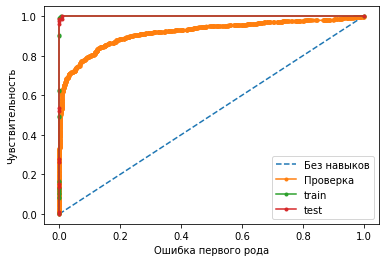

In [336]:
test(train='ling_spam', test='spam_assasin', alg='HGS')

> Epoch: 1, Current best: 1.0, Global best: 1.0, Runtime: 0.25239 seconds
> Epoch: 2, Current best: 1.0, Global best: 1.0, Runtime: 0.28304 seconds
> Epoch: 3, Current best: 1.0, Global best: 1.0, Runtime: 0.38510 seconds
> Epoch: 4, Current best: 1.0, Global best: 1.0, Runtime: 0.32933 seconds
> Epoch: 5, Current best: 1.0, Global best: 1.0, Runtime: 0.27469 seconds
> Epoch: 6, Current best: 1.0, Global best: 1.0, Runtime: 0.27974 seconds
> Epoch: 7, Current best: 1.0, Global best: 1.0, Runtime: 0.23497 seconds
> Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 0.25453 seconds
> Epoch: 9, Current best: 1.0, Global best: 1.0, Runtime: 0.24003 seconds
> Epoch: 10, Current best: 1.0, Global best: 1.0, Runtime: 0.25810 seconds

Learned with ling_spam - tested with spam_assasin
Params: [0.0001 0.0001 0.0001] provided by AO

Accuracy: 0.995850622406639
Precision: 1.0
Recall: 0.9900990099009901
F1-score: 0.9950248756218906

Pred Accuracy: 0.7770714598860149
Pred Precision: 0.705328135

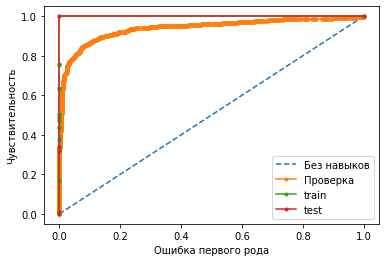

In [337]:
test(train='ling_spam', test='spam_assasin', alg='AO')

> Epoch: 1, Current best: 1.0, Global best: 1.0, Runtime: 0.60643 seconds
> Epoch: 2, Current best: 1.0, Global best: 1.0, Runtime: 0.69739 seconds
> Epoch: 3, Current best: 1.0, Global best: 1.0, Runtime: 0.47190 seconds
> Epoch: 4, Current best: 1.0, Global best: 1.0, Runtime: 0.43105 seconds
> Epoch: 5, Current best: 1.0, Global best: 1.0, Runtime: 0.54723 seconds
> Epoch: 6, Current best: 1.0, Global best: 1.0, Runtime: 0.52881 seconds
> Epoch: 7, Current best: 1.0, Global best: 1.0, Runtime: 0.49658 seconds
> Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 0.50717 seconds
> Epoch: 9, Current best: 1.0, Global best: 1.0, Runtime: 0.49564 seconds
> Epoch: 10, Current best: 1.0, Global best: 1.0, Runtime: 0.66531 seconds

Learned with ling_spam - tested with spam_assasin
Params: [0.0001 0.0001 0.0001] provided by HHO

Accuracy: 0.995850622406639
Precision: 0.9918032786885246
Recall: 1.0
F1-score: 0.9958847736625513

Pred Accuracy: 0.8233231039017974
Pred Precision: 0.76217561

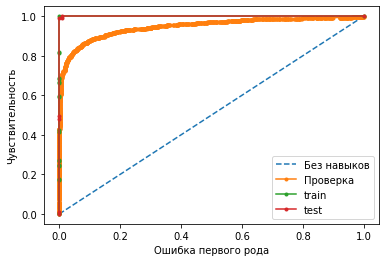

In [338]:
test(train='ling_spam', test='spam_assasin', alg='HHO')


Learned with enron - tested with spam_assasin
Params: [0.0001, 0.1, 0.001] provided by DEFAULT

Accuracy: 0.9888480246767114
Precision: 0.9818223653934652
Recall: 0.9964969640354975
F1-score: 0.9891052387575336

Pred Accuracy: 0.6126698816308637
Pred Precision: 0.5638985579313774
Pred Recall: 0.9943007452871547
Pred F1-score: 0.7196573060447405
Pred ROC aut score: 0.9636754917055884
No Skill: ROC AUC=0.5
Applied: ROC AUC=0.9636754917055884
Trained: ROC AUC=0.9997511349971447
Trained: ROC AUC=0.9989657864241124


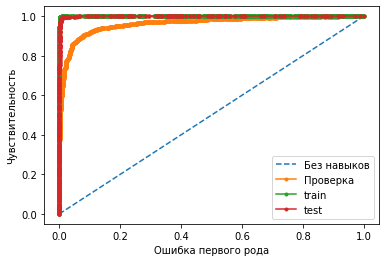

In [339]:
test(train='enron', test='spam_assasin', alg='DEFAULT')

Fitting 5 folds for each of 100 candidates, totalling 500 fits

Learned with enron - tested with spam_assasin
Params: [0.0001, 0.001, 0.01] provided by RSCV

Accuracy: 0.9880175584292324
Precision: 0.980161476355248
Recall: 0.9964821763602252
F1-score: 0.9882544481916502

Pred Accuracy: 0.6041209995615958
Pred Precision: 0.5583394743306312
Pred Recall: 0.9964927663305567
Pred F1-score: 0.7156801007556673
Pred ROC aut score: 0.9634759899218925
No Skill: ROC AUC=0.5
Applied: ROC AUC=0.9634759899218925
Trained: ROC AUC=0.9996579967940172
Trained: ROC AUC=0.9992704774217378


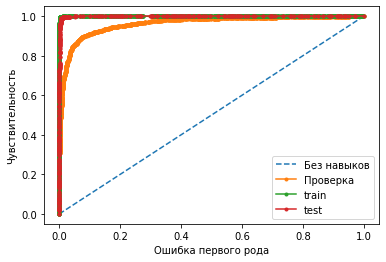

In [340]:
test(train='enron', test='spam_assasin', alg='RSCV')

> Epoch: 1, Current best: 0.9993179759205467, Global best: 0.9993179759205467, Runtime: 14.38255 seconds
> Epoch: 2, Current best: 0.9993208474823442, Global best: 0.9993208474823442, Runtime: 14.01836 seconds
> Epoch: 3, Current best: 0.9993208474823442, Global best: 0.9993208474823442, Runtime: 13.12807 seconds
> Epoch: 4, Current best: 0.9993267032162055, Global best: 0.9993267032162055, Runtime: 12.19905 seconds
> Epoch: 5, Current best: 0.9993267032162055, Global best: 0.9993267032162055, Runtime: 13.63507 seconds
> Epoch: 6, Current best: 0.9993267032162055, Global best: 0.9993267032162055, Runtime: 13.99145 seconds
> Epoch: 7, Current best: 0.9993293495574699, Global best: 0.9993293495574699, Runtime: 13.75272 seconds
> Epoch: 8, Current best: 0.9993293495574699, Global best: 0.9993293495574699, Runtime: 13.12956 seconds
> Epoch: 9, Current best: 0.9993293495574699, Global best: 0.9993293495574699, Runtime: 12.38228 seconds
> Epoch: 10, Current best: 0.9993293495574699, Global b

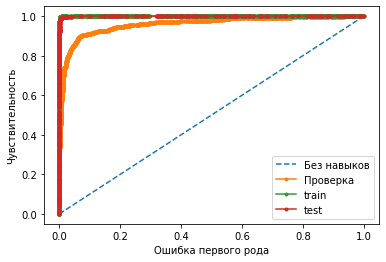

In [341]:
test(train='enron', test='spam_assasin', alg='MRFO')

> Epoch: 1, Current best: 0.9991207143766268, Global best: 0.9991207143766268, Runtime: 3.29746 seconds
> Epoch: 2, Current best: 0.9991207143766268, Global best: 0.9991207143766268, Runtime: 5.64564 seconds
> Epoch: 3, Current best: 0.9991207143766268, Global best: 0.9991207143766268, Runtime: 6.70032 seconds
> Epoch: 4, Current best: 0.9991207143766268, Global best: 0.9991207143766268, Runtime: 7.37796 seconds
> Epoch: 5, Current best: 0.9991207143766268, Global best: 0.9991207143766268, Runtime: 7.46096 seconds
> Epoch: 6, Current best: 0.9991207143766268, Global best: 0.9991207143766268, Runtime: 8.63136 seconds
> Epoch: 7, Current best: 0.9991207143766268, Global best: 0.9991207143766268, Runtime: 8.26777 seconds
> Epoch: 8, Current best: 0.9991207143766268, Global best: 0.9991207143766268, Runtime: 7.70439 seconds
> Epoch: 9, Current best: 0.9991207143766268, Global best: 0.9991207143766268, Runtime: 7.61805 seconds
> Epoch: 10, Current best: 0.9991207143766268, Global best: 0.99

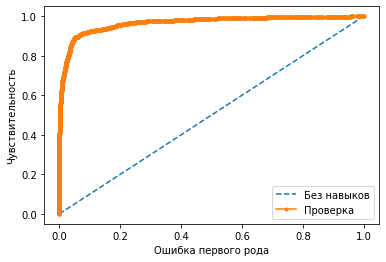

In [291]:
test(train='enron', test='spam_assasin', alg='HGS')

> Epoch: 1, Current best: 0.9991782221081583, Global best: 0.9991782221081583, Runtime: 2.85680 seconds
> Epoch: 2, Current best: 0.9991782221081583, Global best: 0.9991782221081583, Runtime: 2.56974 seconds
> Epoch: 3, Current best: 0.9991782221081583, Global best: 0.9991782221081583, Runtime: 2.54428 seconds
> Epoch: 4, Current best: 0.9991782221081583, Global best: 0.9991782221081583, Runtime: 2.54050 seconds
> Epoch: 5, Current best: 0.9991782221081583, Global best: 0.9991782221081583, Runtime: 2.60848 seconds
> Epoch: 6, Current best: 0.9991782221081583, Global best: 0.9991782221081583, Runtime: 2.53609 seconds
> Epoch: 7, Current best: 0.9991782221081583, Global best: 0.9991782221081583, Runtime: 3.44244 seconds
> Epoch: 8, Current best: 0.9991782221081583, Global best: 0.9991782221081583, Runtime: 3.77870 seconds
> Epoch: 9, Current best: 0.9991782221081583, Global best: 0.9991782221081583, Runtime: 5.07706 seconds
> Epoch: 10, Current best: 0.9991782221081583, Global best: 0.99

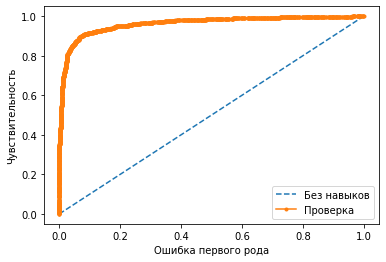

In [292]:
test(train='enron', test='spam_assasin', alg='AO')

> Epoch: 1, Current best: 0.9990674943344171, Global best: 0.9990674943344171, Runtime: 4.80132 seconds
> Epoch: 2, Current best: 0.9990674943344171, Global best: 0.9990674943344171, Runtime: 6.24759 seconds
> Epoch: 3, Current best: 0.9990674943344171, Global best: 0.9990674943344171, Runtime: 5.19544 seconds
> Epoch: 4, Current best: 0.9990674943344171, Global best: 0.9990674943344171, Runtime: 6.11258 seconds
> Epoch: 5, Current best: 0.9990674943344171, Global best: 0.9990674943344171, Runtime: 6.08757 seconds
> Epoch: 6, Current best: 0.9990674943344171, Global best: 0.9990674943344171, Runtime: 5.14085 seconds
> Epoch: 7, Current best: 0.9990714356094196, Global best: 0.9990714356094196, Runtime: 5.02227 seconds
> Epoch: 8, Current best: 0.999088270484073, Global best: 0.999088270484073, Runtime: 4.49154 seconds
> Epoch: 9, Current best: 0.999088270484073, Global best: 0.999088270484073, Runtime: 3.75133 seconds
> Epoch: 10, Current best: 0.999088270484073, Global best: 0.9990882

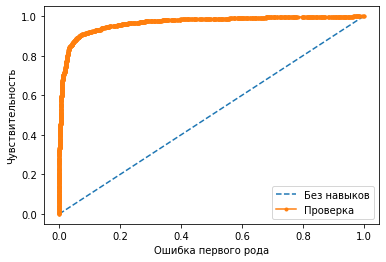

In [293]:
test(train='enron', test='spam_assasin', alg='HHO')


Learned with spam_assasin - tested with enron
Params: [0.0001, 0.1, 0.001] provided by DEFAULT

Accuracy: 0.9964943032427696
Precision: 0.99822695035461
Recall: 0.9946996466431095
F1-score: 0.9964601769911505

Pred Accuracy: 0.6842355034850957
Pred Precision: 0.642982379240817
Pred Recall: 0.8543389633080956
Pred F1-score: 0.7337434973989596
Pred ROC aut score: 0.7975715512994421
No Skill: ROC AUC=0.5
Applied: ROC AUC=0.7975715512994421


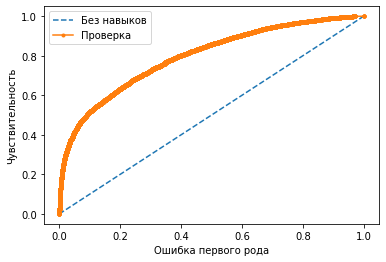

In [294]:
test(train='spam_assasin', test='enron', alg='DEFAULT')

Fitting 5 folds for each of 100 candidates, totalling 500 fits

Learned with spam_assasin - tested with enron
Params: [0.0001, 0.001, 0.001] provided by RSCV

Accuracy: 0.9938650306748467
Precision: 0.9982300884955753
Recall: 0.9894736842105263
F1-score: 0.9938325991189427

Pred Accuracy: 0.6902565623609669
Pred Precision: 0.651093841247024
Pred Recall: 0.8441467676179383
Pred F1-score: 0.7351576171032943
Pred ROC aut score: 0.7996852568303068
No Skill: ROC AUC=0.5
Applied: ROC AUC=0.7996852568303068


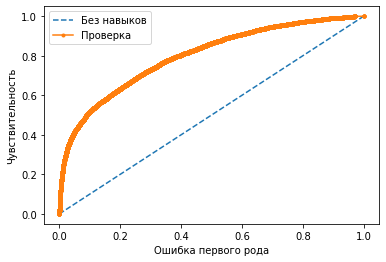

In [295]:
test(train='spam_assasin', test='enron', alg='RSCV')

> Epoch: 1, Current best: 0.9999846247516899, Global best: 0.9999846247516899, Runtime: 1.14504 seconds
> Epoch: 2, Current best: 0.999993849900676, Global best: 0.999993849900676, Runtime: 0.84573 seconds
> Epoch: 3, Current best: 0.999993849900676, Global best: 0.999993849900676, Runtime: 0.92492 seconds
> Epoch: 4, Current best: 0.999993849900676, Global best: 0.999993849900676, Runtime: 0.75552 seconds
> Epoch: 5, Current best: 1.0, Global best: 1.0, Runtime: 0.62185 seconds
> Epoch: 6, Current best: 1.0, Global best: 1.0, Runtime: 0.59874 seconds
> Epoch: 7, Current best: 1.0, Global best: 1.0, Runtime: 0.53388 seconds
> Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 0.51021 seconds
> Epoch: 9, Current best: 1.0, Global best: 1.0, Runtime: 0.50761 seconds
> Epoch: 10, Current best: 1.0, Global best: 1.0, Runtime: 0.52072 seconds

Learned with spam_assasin - tested with enron
Params: [1.78238260e-04 1.00000000e+03 9.99815588e+02] provided by MRFO

Accuracy: 0.9956178790534

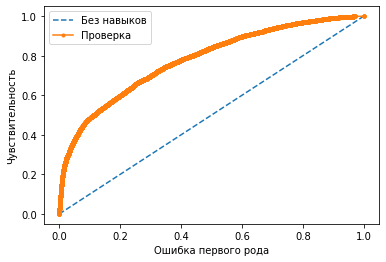

In [296]:
test(train='spam_assasin', test='enron', alg='MRFO')

> Epoch: 1, Current best: 0.9992307881652144, Global best: 0.9992307881652144, Runtime: 0.39303 seconds
> Epoch: 2, Current best: 0.9992307881652144, Global best: 0.9992307881652144, Runtime: 0.45054 seconds
> Epoch: 3, Current best: 0.9995569339831635, Global best: 0.9995569339831635, Runtime: 0.52123 seconds
> Epoch: 4, Current best: 0.9995753950671983, Global best: 0.9995753950671983, Runtime: 0.55586 seconds
> Epoch: 5, Current best: 0.9995753950671983, Global best: 0.9995753950671983, Runtime: 0.61831 seconds
> Epoch: 6, Current best: 0.9995938561512332, Global best: 0.9995938561512332, Runtime: 0.66372 seconds
> Epoch: 7, Current best: 0.9996030866932506, Global best: 0.9996030866932506, Runtime: 0.63334 seconds
> Epoch: 8, Current best: 0.9994523211736326, Global best: 0.9996030866932506, Runtime: 0.60953 seconds
> Epoch: 9, Current best: 0.9996184709299464, Global best: 0.9996184709299464, Runtime: 0.58668 seconds
> Epoch: 10, Current best: 0.9996184709299464, Global best: 0.99

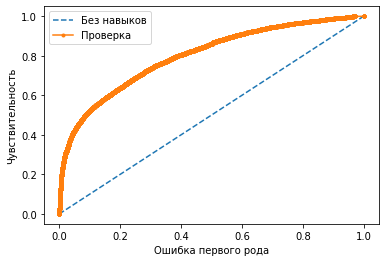

In [297]:
test(train='spam_assasin', test='enron', alg='HGS')

> Epoch: 1, Current best: 0.999508267256746, Global best: 0.999508267256746, Runtime: 0.33486 seconds
> Epoch: 2, Current best: 0.999508267256746, Global best: 0.999508267256746, Runtime: 0.43138 seconds
> Epoch: 3, Current best: 0.999508267256746, Global best: 0.999508267256746, Runtime: 0.36792 seconds
> Epoch: 4, Current best: 0.999508267256746, Global best: 0.999508267256746, Runtime: 0.30314 seconds
> Epoch: 5, Current best: 0.999508267256746, Global best: 0.999508267256746, Runtime: 0.30318 seconds
> Epoch: 6, Current best: 0.999508267256746, Global best: 0.999508267256746, Runtime: 0.31438 seconds
> Epoch: 7, Current best: 0.999508267256746, Global best: 0.999508267256746, Runtime: 0.72025 seconds
> Epoch: 8, Current best: 0.999508267256746, Global best: 0.999508267256746, Runtime: 0.61295 seconds
> Epoch: 9, Current best: 0.999508267256746, Global best: 0.999508267256746, Runtime: 0.57201 seconds
> Epoch: 10, Current best: 0.999508267256746, Global best: 0.999508267256746, Runt

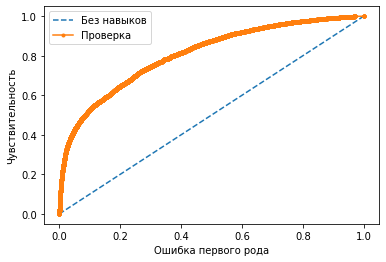

In [298]:
test(train='spam_assasin', test='enron', alg='AO')

> Epoch: 1, Current best: 0.9999569575109144, Global best: 0.9999569575109144, Runtime: 0.59582 seconds
> Epoch: 2, Current best: 0.9999569575109144, Global best: 0.9999569575109144, Runtime: 0.58326 seconds
> Epoch: 3, Current best: 0.9999569575109144, Global best: 0.9999569575109144, Runtime: 0.47214 seconds
> Epoch: 4, Current best: 0.9999569575109144, Global best: 0.9999569575109144, Runtime: 0.61176 seconds
> Epoch: 5, Current best: 0.9999569575109144, Global best: 0.9999569575109144, Runtime: 0.64274 seconds
> Epoch: 6, Current best: 0.9999569575109144, Global best: 0.9999569575109144, Runtime: 0.54378 seconds
> Epoch: 7, Current best: 0.9999569575109144, Global best: 0.9999569575109144, Runtime: 0.55405 seconds
> Epoch: 8, Current best: 0.9999569575109144, Global best: 0.9999569575109144, Runtime: 0.54353 seconds
> Epoch: 9, Current best: 0.9999569575109144, Global best: 0.9999569575109144, Runtime: 0.53532 seconds
> Epoch: 10, Current best: 0.9999569575109144, Global best: 0.99

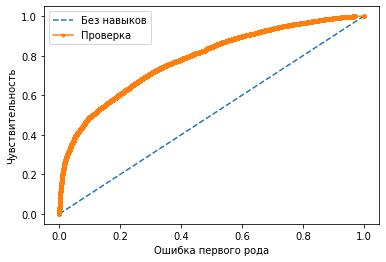

In [299]:
test(train='spam_assasin', test='enron', alg='HHO')